In [1]:
import tqdm as tqdm
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms
from torch.nn.functional import relu
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from skimage import io
import torch
from skimage import color
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.init as init
from PIL import Image, ImageOps
import pickle

from torchvision.models.video import r3d_18


In [2]:
# from resnet import ResNet3D

# #https://github.com/kbressem/faimed3d/blob/main/faimed3d/models/resnet.py#L257

# # Create ResNet18 model
# model = ResNet3D(layers=18, num_classes=3)

# # (Optional) Load Pretrained Weights
# pretrained_path = "/path/to/pretrained_weights.pth"  # Change the path according to your pretrained weights file
# if os.path.exists(pretrained_path):
#     state_dict = torch.load(pretrained_path, map_location=torch.device('cpu'))  # Load the state_dict
#     model.load_state_dict(state_dict)
#     print("Pretrained weights loaded successfully.")
# else:
#     print("No pretrained weights found, initializing model with random weights.")


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('y')
else:
    device = torch.device('cpu')
    print('n')


y


In [4]:
class AbdominalDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label = self.data_frame['target']

        self.transform = transform
    
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir,
                                self.data_frame.iloc[idx, -2])

        image = np.load(img_name)
        label = self.label[idx]

        image = image.astype(np.float32)
        label = label.astype(np.float32)

        resized_image = F.interpolate(torch.tensor(image).unsqueeze(0).unsqueeze(0), size=(128, 128, 128), mode='trilinear', align_corners=False).squeeze().numpy()

        # Normalize the image
        min_image = np.min(resized_image)
        max_image = np.max(resized_image)
        resized_image = (resized_image - min_image) / (max_image - min_image + 1e-4)

        # Convert to tensors
        image = torch.tensor(resized_image).float().unsqueeze(0)
        label = torch.tensor(label).long()

        sample = {'x': image, 'y': label}

        if self.transform:
            sample = self.transform(sample)

        return sample



In [5]:
def train_model(model, dataloader, optimizer,  loss_fn, num_epochs = 10, verbose = False):
    acc_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    best_acc = 0
    phases = ['train','validate']
    since = time.time()
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            if p == 'train':
                model.train()
            else:
                model.eval()
            for data in dataloader[p]:
                optimizer.zero_grad()            
                image = data['x'].to(device)
                label = data['y'].to(device)
                output = model(image)
                loss = loss_fn(output, label)
                _, preds = torch.max(output, dim = 1)
                num_imgs = image.size()[0]
                running_correct += torch.sum(preds ==label).item()
                running_loss += loss.item()*num_imgs
                running_total += num_imgs
                if p== 'train':
                    loss.backward()
                    optimizer.step()
            epoch_acc = float(running_correct/running_total)
            epoch_loss = float(running_loss/running_total)
            if verbose or (i%10 == 0):
                print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f}'.format(p, epoch_loss, epoch_acc))

            acc_dict[p].append(epoch_acc)
            loss_dict[p].append(epoch_loss)
            if p == 'validate':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    return model, acc_dict, loss_dict


In [7]:

bs = 4

torch.cuda.empty_cache()

current_directory = os.getcwd()
data_directory = os.path.join(current_directory, '..', 'data')

dataset = {'train': AbdominalDataset(os.path.join(data_directory, 'train_sample.csv'),'/vast/amr10211/deep_learning_final_project/images_preprocessed/'), 
           'validate': AbdominalDataset(os.path.join(data_directory, 'val_sample.csv'),'/vast/amr10211/deep_learning_final_project/images_preprocessed/'), 
           'test': AbdominalDataset(os.path.join(data_directory, 'test_sample.csv'),'/vast/amr10211/deep_learning_final_project/images_preprocessed/')}
dataloader = {x: DataLoader(dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate']}

model = r3d_18(weights=True)
model.stem = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, 3)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

model, acc_dict, loss_dict = train_model(model, dataloader, optimizer, loss_fn=criterion, num_epochs = 5,  verbose=True)


/ext3/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0/4
----------
Phase:train, epoch loss: 0.5723 Acc: 0.7766
Phase:validate, epoch loss: 0.4013 Acc: 0.8750
Epoch: 1/4
----------
Phase:train, epoch loss: 0.3356 Acc: 0.8989
Phase:validate, epoch loss: 0.6440 Acc: 0.7917
Epoch: 2/4
----------
Phase:train, epoch loss: 0.2481 Acc: 0.9149
Phase:validate, epoch loss: 0.5376 Acc: 0.8750
Epoch: 3/4
----------
Phase:train, epoch loss: 0.2015 Acc: 0.9202
Phase:validate, epoch loss: 0.3049 Acc: 0.8750
Epoch: 4/4
----------
Phase:train, epoch loss: 0.1851 Acc: 0.9255
Phase:validate, epoch loss: 0.7219 Acc: 0.8333
Training complete in 10m 6s
Best val acc: 0.875000


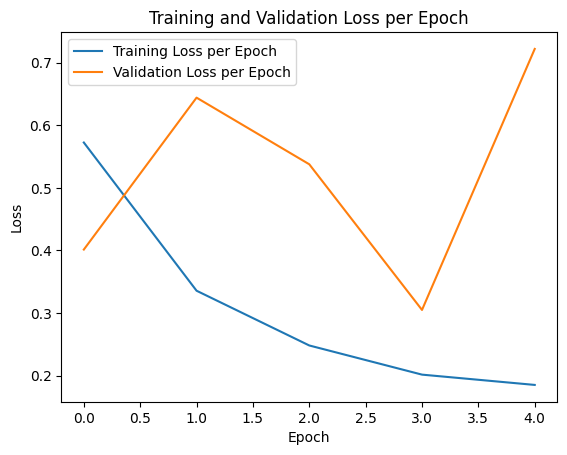

In [8]:
plt.plot(range(0,len(loss_dict['train'])),loss_dict['train'], label = 'Training Loss per Epoch')
plt.plot(range(0,len(loss_dict['validate'])),loss_dict['validate'],  label = 'Validation Loss per Epoch')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# torch.save(model.state_dict(), 'classification_model_resnet18_1.pth')